# Méthodologie


## Planification

## Prétraitement

## Identification

---------------------------------------------------------------------

## Planification

Planifier des trajectoires interprétables physiquement : 
L'inertie et la masse sont fonction de l'accélération. Planifions des trajectoires avec des accélérations maximales.

Les frottements varient en fonction de la vitesse. Planifions des trajectoires à différentes vitesses.

L'identifiabilité des paramètres est une problématique fondamentale. Elle peut être vérifiée d'un point de vue théorique mais aussi en simulation. 

Chaque fois que cela est possible, il faut tester les algorithmes de problèmes inverses en simulation. Ceci permet de detecter les problèmes

* d'identifiabilité structurelle
* d'identifiabilité conjoncturelle

Par ailleurs, cela permet de se poser des question sur les valeurs a priori des paramètres à identifier.


In [1]:
import numpy as np
from experiences import experience2
couple_mesure, q, T, r = experience2()

## Prétraitement

La position est donné par un codeur. Compte tenu du schéma numérique :

$$ dx(n) =  \frac{x(n+1)-x(n-1)}{2T}$$

L'erreur sur la vitesse est multipliée par $0,5/T$ et celle sur l'accélération par $0,25/T^2$


Cette erreur perturbe la matrice d'observation... Qui est supposée non bruitée dans le cadre des moindres carrés...


<img src="bode_filtrage.png" />

L'analyse fréquentielle permet de comprendre le phénomène. Diviser revient à multiplier par $2\pi f$. Cette erreur peut être limitée par un filtrage passe pas en supposant qu'il n'y a pas de phénomène haute fréquence.

Dans notre cas, il y a un phénomène haute fréquence qui est la vibration mais nous devons la retirer car elle ne rentre pas das notre modélisation.

La fréquence de coupure du filtre est réglée à $f_c =0.5$ Hz

## Référence

Theory and application of digital signal processing - Lawrence R. Rabiner, Bernard Gold

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline 
fc=0.4 ;
fn = 1/T ;
fcn=fc/fn
Nbutter=3;
b, a = signal.butter(Nbutter, fcn, btype='low', analog=False)


In [3]:
qf=signal.filtfilt(b, a, q)
# calcul des vitesses et accélération 
dq=(qf[2:]-qf[:-2])/(2*T)
ddq=(dq[2:]-dq[:-2])/(2*T)

# tous les signaux sont mis à la même taille avec un anneau
taille_anneau = 90*Nbutter 

ddq=ddq[(taille_anneau):(-taille_anneau)]
dq=dq[(taille_anneau+1):(-(taille_anneau+1))]

couple_mesuref=signal.filtfilt(b, a, couple_mesure)
couple_mesurefa = couple_mesuref[(taille_anneau+2):(-(taille_anneau+2))]

# calcul de W et Y
W = np.transpose([r*r*ddq, r*r*dq,r*np.ones(np.size(dq))])
Y=couple_mesurefa


Notre modèle n'est pas universel

Filtrage parallèle pour concentrer l’identification dans la bande
fréquentielle valide / Nettoyage des empreintes


Attention à la surinformation : une ligne peut être
obtenue par combinaisons linéaires des autres =
décimation

c'est le paradoxe de l’empereur de Chine


In [4]:
fcd=0.5*fc;
rd=round((1/T)/fcd)
rd1=round(rd/10);
rd2=10
Wd10=signal.decimate(W[:,0],rd1)
Wd11=signal.decimate(W[:,1],rd1)
Wd12=signal.decimate(W[:,2],rd1)
Wd1=[Wd10,Wd11,Wd12]
Wd1=np.transpose(Wd1)
Yd1=signal.decimate(Y,rd1)

Wd20=signal.decimate(Wd10,rd2)
Wd21=signal.decimate(Wd11,rd2)
Wd22=signal.decimate(Wd12,rd2)
Wd=[Wd20,Wd21,Wd22]
Wd=np.transpose(Wd)
Yd=signal.decimate(Yd1,rd2)





## Identification

In [5]:
X=np.linalg.lstsq(Wd,Yd)[0]
residu=Yd-Wd.dot(X)
nech=np.size(Yd)
npar=np.size(X);
nddl = nech-npar;
residut=np.transpose(residu)
sigma=np.sqrt(residut.dot(residu)/nddl)
mu=np.mean(residu)

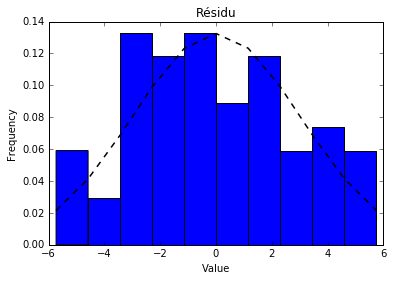

In [6]:
import matplotlib.pyplot as plt
import pylab as py
%matplotlib inline
bins=10
n, bins, patches = plt.hist(residu,bins,normed=1)
plt.title("Résidu")
plt.xlabel("Value")
plt.ylabel("Frequency")
y = py.normpdf(bins, mu ,sigma)
l = plt.plot(bins, y, 'k--', linewidth=1.5)

In [7]:
from scipy.stats import anderson
anderson(residu, dist='norm')

AndersonResult(statistic=0.34778638584786847, critical_values=array([ 0.543,  0.619,  0.742,  0.866,  1.03 ]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

### Calculer la matrice variance covariance

In [8]:
q,r=np.linalg.qr(Wd,mode='reduced')

In [9]:
rt=np.transpose(r)
variance=np.linalg.inv(rt.dot(r))*sigma*sigma;
ecart_variance_parametres=np.diag(variance)
ecart_type_parametres=np.sqrt(ecart_variance_parametres)

In [10]:
print(ecart_type_parametres)

[ 30.95248959   1.87218952   3.45814743]


In [11]:
print('La masse du compacteur avec l''inertie des billes (divisées par r^2) est {:.1f} t)'.format(
      X[0]/1000))
print('Le frottement visqueux {:.1f}'.format(
      X[1]))
print('Le frottement sec est {:.0f}'.format(
      X[2]))

La masse du compacteur avec linertie des billes (divisées par r^2) est 12.6 t)
Le frottement visqueux 100.7
Le frottement sec est 979


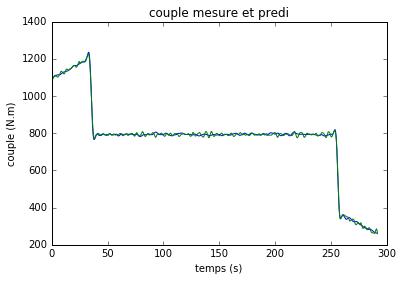

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline 

couple_predit=np.transpose(W.dot(X))

nech=np.size(Y)
temps=T*np.arange(1,nech+1)
plt.figure(1)
plt.plot(temps, Y, temps, couple_predit)

plt.title('couple mesure et predi')
plt.xlabel('temps (s)')
plt.ylabel('couple (N.m)')

* Vérification sur un essai qui n'a pas servi à l'identification

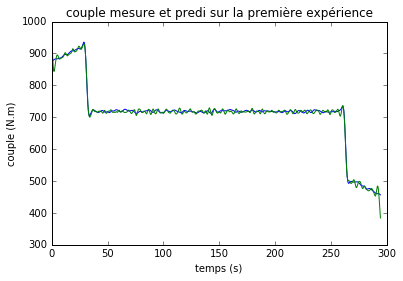

In [13]:
import numpy as np
from experiences import experience1
couple_mesure1, q1, T1, r1 = experience1()
fc1=0.4 ;
fn1 = 1/T1 ;
fcn1=fc1/fn1
Nbutter=3;
b, a = signal.butter(Nbutter, fcn1, btype='low', analog=False)

qf1=signal.filtfilt(b, a, q1)

# calcul des vitesses et accélération 
dq1=(qf1[2:]-qf1[:-2])/(2*T1)
ddq1=(dq1[2:]-dq1[:-2])/(2*T1)

# tous les signaux sont mis à la même taille avec un anneau
taille_anneau = 90*Nbutter 

ddq1=ddq1[(taille_anneau):(-taille_anneau)]
dq1=dq1[(taille_anneau+1):(-(taille_anneau+1))]

couple_mesuref1=signal.filtfilt(b, a, couple_mesure1)
couple_mesurefa1 = couple_mesuref1[(taille_anneau+2):(-(taille_anneau+2))]

# calcul de W et Y
W1 = np.transpose([r1*r1*ddq1, r1*r1*dq1,r1*np.ones(np.size(dq1))])
Y1=couple_mesurefa1

couple_predit1=np.transpose(W1.dot(X))

nech=np.size(Y1)
temps1=T1*np.arange(1,nech+1)
plt.figure(1)
plt.plot(temps1, Y1, temps1, couple_predit1)

plt.title('couple mesure et predi sur la première expérience')
plt.xlabel('temps (s)')
plt.ylabel('couple (N.m)')

Les résultats peuvent être améliorés en replanifiant des expériences. 

Dans le cas présent, en mettant en oeuvre des essais avec le compacteur sur chandelle.

# Utilisation du logiciel R

In [14]:
%load_ext rpy2.ipython

%R -i Yd,Wd
%R OBS <- as.data.frame(Wd)
%R lmout <- lm(Yd ~.-1, data=OBS)
%R print(summary(lmout))

ImportError: /home/vandanjon/applications_locales/anaconda3/bin/../lib/libreadline.so.6: undefined symbol: PC